In [1]:
import pyarrow.parquet as pq;
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize']= (15,6)

In [2]:
df = pd.read_parquet('querystore-featurized.gzip')

## Gesucht ist ein Chart mit den Top N Abfragen nach Anzahl Ausführungen

In [3]:
dfqueries=df.groupby(df.query_sql_text)['count_executions'].agg('sum').reset_index()



In [4]:
dfqueries["short_sql"] = dfqueries["query_sql_text"].str.slice(0, 100)

In [5]:
dfqueries.head()

,query_sql_text,count_executions,short_sql
0,"(@1 tinyint,@2 tinyint,@3 tinyint)SELECT [p].[...",1,"(@1 tinyint,@2 tinyint,@3 tinyint)SELECT [p].[..."
1,"(@1 tinyint,@2 varchar(8000),@3 numeric(4,0))S...",8,"(@1 tinyint,@2 varchar(8000),@3 numeric(4,0))S..."
2,(@LogPath nvarchar(512))select @LogPath=substr...,9,(@LogPath nvarchar(512))select @LogPath=substr...
3,(@MasterPath nvarchar(512))select @MasterPath=...,9,(@MasterPath nvarchar(512))select @MasterPath=...
4,(@QuerySearchText nvarchar(31))SELECT TOP 500 ...,1,(@QuerySearchText nvarchar(31))SELECT TOP 500 ...


In [6]:
dfsorted = dfqueries.sort_values('count_executions',ascending = False)
dfsorted.head(10)
top10 = dfsorted[0:30]

<BarContainer object of 30 artists>

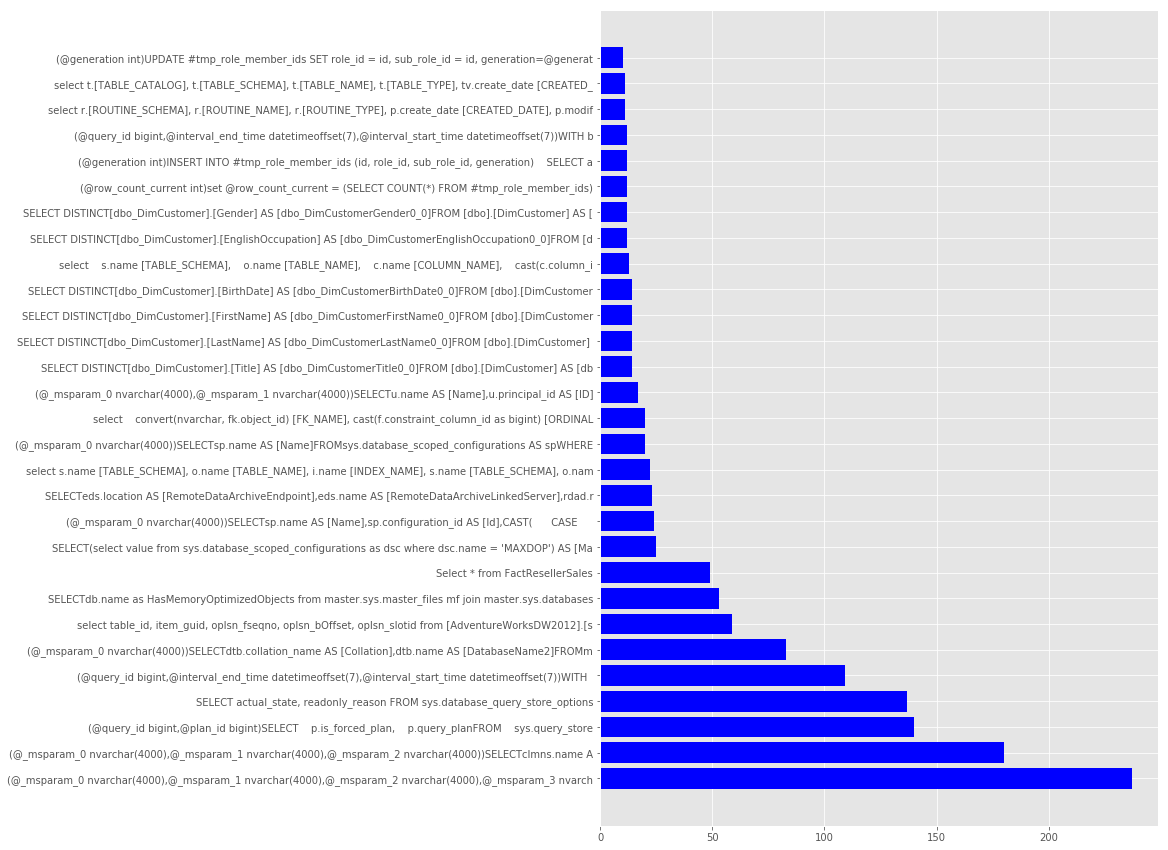

In [7]:
plt.rcParams['figure.figsize']= (10,15)
plt.barh(top10.short_sql, top10.count_executions, color="blue")


## Gesucht ist ein Chart mit Anzahl Executions und Summe der AVG Duration im Zeitverlauf für den Monat Juli

In [8]:
dftime=df.groupby(df.start_time)['count_executions','avg_duration'].agg('sum').reset_index()


dftime['hour'] = dftime.start_time.dt.hour
dftime['day'] = dftime.start_time.dt.day
dftime['month'] = dftime.start_time.dt.month
dftime['year'] = dftime.start_time.dt.year
dftime['date'] = dftime.start_time.dt.date

avgdurationdf = df.groupby(['start_time'])['avg_duration'].mean().reset_index()
#avgdurationdf
dftime['avg_duration_avg'] = avgdurationdf['avg_duration']


dftime.set_index('start_time')


#timeslicer:

dftimesliced = dftime.loc[dftime['month'] > 6]




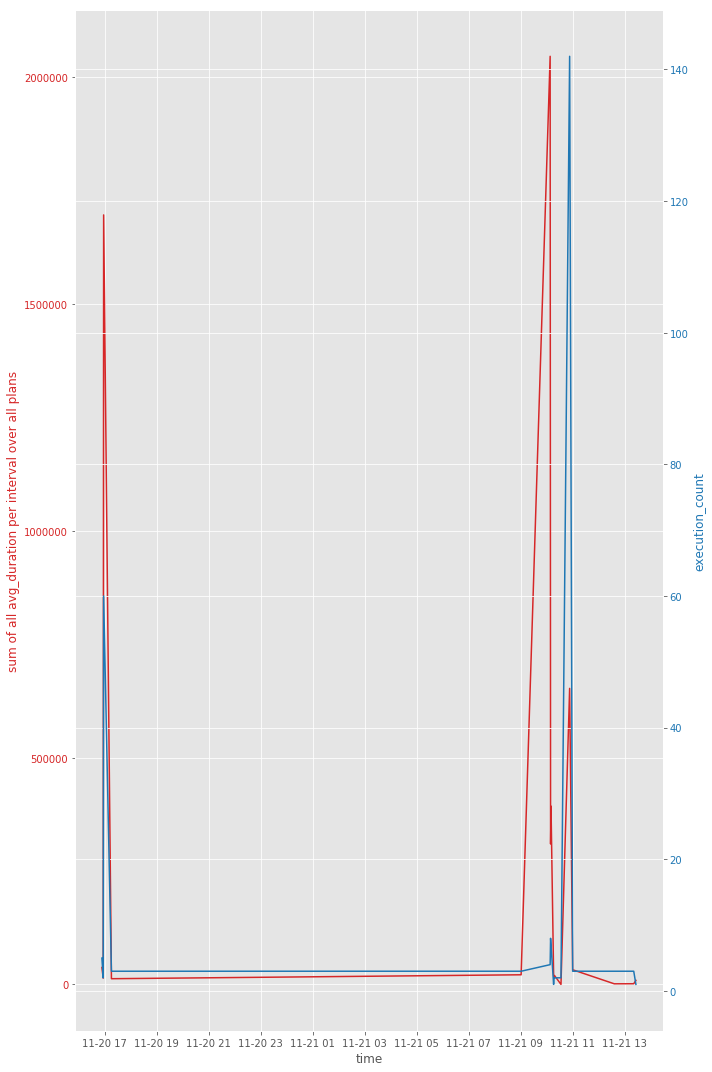

In [9]:
dftime = dftimesliced
fig, ax1 = plt.subplots()


color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('sum of all avg_duration per interval over all plans', color=color)
ax1.plot(dftime.start_time,dftime.avg_duration, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


color = 'tab:blue'
ax2.set_ylabel('execution_count', color=color)  # we already handled the x-label with ax1
ax2.plot(dftime.start_time,dftime.count_executions, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [10]:
df.to_csv('powerbioutput.csv', sep='\t', encoding='utf-8')